In [4]:
! pip install -U langchain-google-genai

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ---------------------- ----------------- 0.8/1.4 MB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.7 MB 3.7 MB/s eta 0:00:02
   ----------- ---------------------------- 1.3/4.7 MB 3.6 MB/s eta 0:00:01
   ----------------- ---------------------- 2.1/4.7 MB 3.5 MB/s eta 0:00:01
   ---------------------- ----------------- 2.6/4.7 MB 3.3 MB/s eta 0:00:01
   ------------------------------- -------- 3.7/4.7 MB 3.5 MB/s eta 0:00:01
   ------------------------------------- -- 4.5/4.7 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 4.7/4.7 MB 3.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
import os


In [6]:
# Gmail API Configuration
SCOPES = ['https://www.googleapis.com/auth/gmail.modify']
CREDENTIALS_FILE = '../credentials/credentials.json'
TOKEN_FILE = 'token.json'

In [36]:
class GmailHandler:
    """Minimal Gmail fetcher
    Fetch the labels and unread emails from Gmail using Gmail API.
    """

    def __init__(self):
        self.service = None
        self.authenticate()

    def authenticate(self):
        """Authenticate with Gmail API"""
        creds = None

        # Load existing token
        if os.path.exists(TOKEN_FILE):
            creds = Credentials.from_authorized_user_file(TOKEN_FILE, SCOPES)
            print("creds", creds.to_json())

        # If no valid token, log in
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(CREDENTIALS_FILE, SCOPES)
                creds = flow.run_local_server(port=0)
            # Save token
            with open(TOKEN_FILE, 'w') as token:
                token.write(creds.to_json())

        self.service = build('gmail', 'v1', credentials=creds)

    def get_labels(self):
        """Fetch and display only user-created Gmail labels"""
        try:
            results = self.service.users().labels().list(userId='me').execute()
            labels = results.get('labels', [])

            # Filter only user-created labels
            user_labels = [label for label in labels if label.get('type') == 'user']

            if not user_labels:
                print("⚠️ No user-created labels found.")
                return []

            print("🏷️  Your Gmail Labels (created by you):")
            for label in user_labels:
                print(f" - {label['name']}")
            print()
            return user_labels

        except Exception as e:
            print(f"❌ Error fetching labels: {e}")
            return []
        
    def get_unread_emails(self, max_results=50):
        """Fetch unread emails"""
        try:
            results = self.service.users().messages().list(
                userId='me',
                labelIds=['INBOX'],
                q='is:unread',
                maxResults=max_results
            ).execute()

            messages = results.get('messages', [])
            if not messages:
                print("✅ No unread emails found.")
                return []

            print(f"📬 Found {len(messages)} unread emails:\n")
            emails = []
            for msg in messages:
                details = self.get_email_details(msg['id'])
                if details:
                    emails.append(details)
            return emails

        except Exception as e:
            print(f"❌ Error fetching emails: {e}")
            return []
        
    def get_email_details(self, msg_id):
        """Get full email details + labels"""
        try:
            msg = self.service.users().messages().get(
                userId='me', id=msg_id, format='full'
            ).execute()

            headers = msg['payload']['headers']
            subject = next((h['value'] for h in headers if h['name'] == 'Subject'), '(No Subject)')
            sender = next((h['value'] for h in headers if h['name'] == 'From'), '(Unknown)')
            snippet = msg.get('snippet', '')
            labels = msg.get('labelIds', [])

            print(f"📧 From: {sender}")
            print(f"   Subject: {subject}")
            print(f"   Labels: {', '.join(labels) if labels else '(No Labels)'}")
            print(f"   Snippet: {snippet}...\n")

            return {"id": msg_id, "from": sender, "subject": subject, "labels": labels, "snippet": snippet}

        except Exception as e:
            print(f"❌ Error reading email: {e}")
            return None

    def get_emails_since(self, hours: int = 24, max_results: int = 50):
        """Fetch emails received in the last 'hours' hours"""
        try:
            query = f"newer_than:{hours}h"
            results = self.service.users().messages().list(
                userId='me',
                labelIds=['INBOX'],
                q=query,
                maxResults=max_results
            ).execute()

            messages = results.get('messages', [])
            if not messages:
                print(f"✅ No emails found in the last {hours} hours.")
                return []

            print(f"📬 Found {len(messages)} emails from the last {hours} hours:\n")
            emails = []
            for msg in messages:
                details = self.get_email_details(msg['id'])
                if details:
                    emails.append(details)
            return emails

        except Exception as e:
            print(f"❌ Error fetching emails: {e}")
            return []

    def check_label_exists(self, label_name):
        """Check if a label exists"""
        labels = self.get_labels()
        for label in labels:
            if label['name'].lower() == label_name.lower():
                return True
        return False
    
    def create_label(self, label_name):
        """Create a new label"""
        label_body = {
            'name': label_name,
            'labelListVisibility': 'labelShow',
            'messageListVisibility': 'show'
        }
        try:
            label = self.service.users().labels().create(
                userId='me',
                body=label_body
            ).execute()
            print(f"✅ Label '{label_name}' created.")
            return label
        except Exception as e:
            print(f"❌ Error creating label: {e}")
            return None
        
    def migrate_old_labels(self, old_to_new_map: dict):
        """
        Move emails from old labels to new labels, then delete the old labels.
        
        old_to_new_map: dict mapping old label names -> new label names
            e.g., {"Ghosted": "Follow-up 💬", "Rejection": "Rejected ❌"}
        """
        for old_label, new_label in old_to_new_map.items():
            print(f"\n📦 Migrating emails from '{old_label}' → '{new_label}'")
            
            # 1️⃣ Get old label ID
            labels = self.get_labels()
            old_label_obj = next((l for l in labels if l['name'].lower() == old_label.lower()), None)
            if not old_label_obj:
                print(f"⚠️ Old label '{old_label}' not found, skipping.")
                continue
            old_label_id = old_label_obj['id']

            # 2️⃣ Ensure new label exists
            if not self.check_label_exists(new_label):
                self.create_label(new_label)
            new_label_id = next((l['id'] for l in self.get_labels() if l['name'].lower() == new_label.lower()), None)

            # 3️⃣ Fetch emails with old label
            try:
                results = self.service.users().messages().list(
                    userId='me',
                    labelIds=[old_label_id]
                ).execute()
                messages = results.get('messages', [])
                if not messages:
                    print(f"✅ No emails found under '{old_label}'")
                    continue

                print(f"📬 Found {len(messages)} emails under '{old_label}'")

                # 4️⃣ Move emails to new label
                for msg in messages:
                    self.service.users().messages().modify(
                        userId='me',
                        id=msg['id'],
                        body={'addLabelIds': [new_label_id], 'removeLabelIds': [old_label_id]}
                    ).execute()
                print(f"✅ Migrated {len(messages)} emails to '{new_label}'")

            except Exception as e:
                print(f"❌ Error migrating emails from '{old_label}': {e}")

            # 5️⃣ Delete old label
            try:
                self.service.users().labels().delete(userId='me', id=old_label_id).execute()
                print(f"🗑️ Deleted old label '{old_label}'")
            except Exception as e:
                print(f"❌ Error deleting old label '{old_label}': {e}")



In [12]:
# handler = GmailHandler()

In [13]:
# handler.get_labels()

In [14]:
# handler.get_unread_emails()

In [15]:
# handler.get_emails_since(hours=12, max_results=20)

In [29]:
# ================================
# Improved Email Classification Prompt
# ================================

EMAIL_CLASSIFICATION_PROMPT = """
You are a precise email classifier for job-related emails.
Your task is to assign the email to EXACTLY ONE of the following category keys:

{categories}

=========================
CATEGORY DEFINITIONS
=========================

application_confirmed:
    Confirmation that an application was received.

interview_request:
    Recruiter requesting to schedule an interview or providing interview scheduling links.

interview_reminder:
    Reminders or confirmations for upcoming interviews.

offer:
    Job offer emails, offer letters, verbal offers, or negotiation instructions.

rejected:
    Rejection emails stating the applicant is not moving forward.

assessment:
    Coding tests, online assessments, take-home assignments.

follow_up:
    Recruiter checking in, following up, asking for updates, or next-steps clarification.

job_alert:
    Job recommendations, alerts about openings, job board notifications.

newsletter:
    Company newsletters, weekly digests, marketing content.

spam:
    Irrelevant, suspicious, non-job content.

uncategorized:
    Use ONLY if the email clearly does not fit any category above.

=========================
CATEGORY PRIORITY
=========================
interview_request > interview_reminder > offer > rejected > assessment >
follow_up > application_confirmed > job_alert > newsletter > spam > uncategorized

=========================
EMAIL TO CLASSIFY
=========================

Subject: {subject}
Snippet: {snippet}

=========================
RESPONSE RULES
=========================
- Respond with ONLY the category key.
- No explanation.
- No extra text.
- No formatting.
Category:
"""


In [30]:
JOB_CATEGORIES = {
    "application_confirmed": {"label": "Applied ✓"},
    "interview_request": {"label": "Interview 📅"},
    "interview_reminder": {"label": "Interview Reminder ⏰"},
    "offer": {"label": "Job Offer 🎉"},
    "rejected": {"label": "Rejected ❌"},
    "assessment": {"label": "Assessment 📝"},
    "follow_up": {"label": "Follow-up 💬"},
    "job_alert": {"label": "Job Alert 🔔"},
    "newsletter": {"label": "Newsletter 📰"},
    "spam": {"label": "Spam 🗑️"},
    "uncategorized": {"label": "Other 📧"}
}


In [33]:
from langchain_core.prompts import PromptTemplate
from langchain_classic.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI

class EmailCategorizerUsingGemini:
    """Email categorizer using Google Gemini LLM"""
    
    def __init__(self,google_api_key, model_name="gemini-2.5-flash"):
        self.llm = ChatGoogleGenerativeAI(google_api_key=google_api_key,
            model=model_name)
        self.prompt_template = PromptTemplate(
            input_variables=["categories", "subject", "snippet"],
            template=EMAIL_CLASSIFICATION_PROMPT
        )
        self.chain = LLMChain(llm=self.llm, prompt=self.prompt_template)


    def categorize(self, emails):
        """Categorize a list of emails"""
        results = []
        categories_str = ", ".join(JOB_CATEGORIES.keys())

        for email in emails:
            subject = email.get("subject", "")
            snippet = email.get("snippet", "")
            try:
                response = self.chain.run(
                    subject=subject,
                    snippet=snippet,
                    categories=categories_str
                ).strip().lower()

                # match valid category or fallback
                category_key = (
                    response if response in JOB_CATEGORIES else "uncategorized"
                )
                label = JOB_CATEGORIES[category_key]["label"]

                email["category"] = category_key
                email["category_label"] = label
                results.append(email)

                print(f"📧 {subject[:60]} → {label}")

            except Exception as e:
                print(f"❌ Error classifying email '{subject}': {e}")

        return results


In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_classic.chains import LLMChain
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI


class EmailCategorizerUsingGroq:
    """Categorizes emails using Groq + Llama via LangChain.
    Goes through a list of emails and classifies each into predefined job-related categories.
    """

    def __init__(self, groq_api_key, model_name="llama-3.1-8b-instant"):
        self.model = ChatGroq(api_key=groq_api_key, model=model_name)
        self.prompt = PromptTemplate(
            input_variables=["subject", "snippet", "categories"],
            template=EMAIL_CLASSIFICATION_PROMPT
        )
        self.chain = LLMChain(llm=self.model, prompt=self.prompt)

    def categorize(self, emails):
        """Categorize a list of emails"""
        results = []
        categories_str = ", ".join(JOB_CATEGORIES.keys())

        for email in emails:
            subject = email.get("subject", "")
            snippet = email.get("snippet", "")
            try:
                response = self.chain.run(
                    subject=subject,
                    snippet=snippet,
                    categories=categories_str
                ).strip().lower()

                # match valid category or fallback
                category_key = (
                    response if response in JOB_CATEGORIES else "uncategorized"
                )
                label = JOB_CATEGORIES[category_key]["label"]

                email["category"] = category_key
                email["category_label"] = label
                results.append(email)

                print(f"📧 {subject[:60]} → {label}")

            except Exception as e:
                print(f"❌ Error classifying email '{subject}': {e}")

        return results


In [ ]:
class GmailLLMAgent:
    """
    Fetch emails from Gmail Classifier, classify them using LLM Class, 
    and apply labels based on the predicted category and update it in Gmail.

    """

    def __init__(self, gmail_handler: GmailHandler, categorizer: EmailCategorizerUsingGemini):
        self.gmail = gmail_handler
        self.categorizer = categorizer

    def process_emails(self, hours: int = 24, max_results: int = 5):
        """
        Fetch emails from the last 'hours' hours, classify, and label them.
        """
        emails = self.gmail.get_emails_since(hours=hours, max_results=max_results)
        if not emails:
            print("📭 No emails to process.")
            return

        print(f"📬 Processing {len(emails)} emails...\n")

        # 1️⃣ Classify emails
        categorized_emails = self.categorizer.categorize(emails)

        # 2️⃣ Apply labels
        for email in categorized_emails:
            label_name = email.get("category_label", "Other 📧")

            # create label if not exists
            if not self.gmail.check_label_exists(label_name):
                self.gmail.create_label(label_name)

            # apply label
            try:
                self.gmail.service.users().messages().modify(
                    userId='me',
                    id=email['id'],
                    body={'addLabelIds': [self._get_label_id(label_name)],
                          'removeLabelIds': []}  # optional: remove UNREAD
                ).execute()
                print(f"✅ Labeled: {email['subject'][:50]} → {label_name}")
            except Exception as e:
                print(f"❌ Error applying label to '{email['subject']}': {e}")

    def _get_label_id(self, label_name: str):
        """Return Gmail label ID, create if it doesn't exist"""
        labels = self.gmail.get_labels()
        for label in labels:
            if label['name'].lower() == label_name.lower():
                return label['id']
        # create if not found
        label = self.gmail.create_label(label_name)
        return label['id'] if label else None


In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()


# Initialize Gmail handler
gmail_handler = GmailHandler()

# Initialize Groq email categorizer
groq_api_key = os.getenv("GROQ_API_KEY")
categorizer = EmailCategorizerUsingGemini(groq_api_key)

# Create LLM Agent
agent = GmailLLMAgent(gmail_handler, categorizer)

# Process emails from last 24 hours
agent.process_emails(hours=24, max_results=50)


creds {"token": "ya29.a0ATi6K2u8ae8fTAyDuVZO3_jMmcMd2Ifm_RHySU-yxgzUWPpi-F62Ge9FsKR26yD1gq8p7dLuglDIOwOjTE1HUNQJ4VOW9aa9NjzbQ0YsSRcUqqczDhYWoRz7zHM532QQm4_Jxd0jZimg6kds_Y7ToqE244raJH8p77r7vs9AlCuxaWUhSj7t1mX9c_yoOIApWdg_GqYXaCgYKAS0SARMSFQHGX2MiFZukLWjbupDNNX7H85miQw0207", "refresh_token": "1//05TrQi9MqXxoTCgYIARAAGAUSNwF-L9IrtueZ2vud33vXcr9aQhXc0R1T7ekq0Lv2GFgN_cvw8k0yDL-GLPc46lwwoOOwCdir4lc", "token_uri": "https://oauth2.googleapis.com/token", "client_id": "643813721017-2err0bl1c4ueihcvsgbqm7cckvulsip6.apps.googleusercontent.com", "client_secret": "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", "scopes": ["https://www.googleapis.com/auth/gmail.modify"], "universe_domain": "googleapis.com", "account": "", "expiry": "2025-11-14T18:43:46Z"}


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_23044\3484252649.py:40: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use `RunnableSequence, e.g., `prompt | llm`` instead.
  self.chain = LLMChain(llm=self.model, prompt=self.prompt)


📬 Found 50 emails from the last 24 hours:

📧 From: LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
   Subject: “Canada”: Toronto Paramedic Services (Formerly Toronto EMS) - OPERATIONS SUPPORT OFFICER (Ceremonial Documents), STRATEGIC PROTOCOL AND EXTERNAL RELATIONS
   Labels: UNREAD, CATEGORY_UPDATES, INBOX
   Snippet: Toronto Paramedic Services (Formerly Toronto EMS) OPERATIONS SUPPORT OFFICER (Ce...

📧 From: Microsoft Reactor Toronto <info@email.meetup.com>
   Subject: 📅 Just scheduled: Maintaining reliable codebases with GitHub Code Quality
   Labels: UNREAD, IMPORTANT, CATEGORY_UPDATES, INBOX
   Snippet: Microsoft Reactor Toronto invites you to a new event ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌...

📧 From: "BestBuy.ca" <newsletter@e.bestbuy.ca>
   Subject: Call of Duty: Black Ops 7 available now.
   Labels: CATEGORY_PROMOTIONS, UNREAD, INBOX
   Snippet: Plus, save up to 25% on select gaming accessories. ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿ ͏ ‌ ﻿...

📧 From: AI Tinkerers - Toronto <toronto-events@mail

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_23044\3484252649.py:51: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain-classic 0.1.0 and will be removed in 1.0. Use `invoke` instead.
  response = self.chain.run(


📧 “Canada”: Toronto Paramedic Services (Formerly Toronto EMS)  → Other 📧
📧 📅 Just scheduled: Maintaining reliable codebases with GitHub → Job Alert 🔔
📧 Call of Duty: Black Ops 7 available now. → Job Alert 🔔
📧 AI Tinkerers Toronto x Two Small Fish - VIP Dinner! → Job Alert 🔔
📧 Is your potential boss toxic? → Newsletter 📰
📧 Andrew Bryan posted in Canadian Networking. → Job Alert 🔔
📧 Andrew Bryan posted in Canadian Networking. → Job Alert 🔔
📧 ✈ Book Budget-Friendly Deals! → Newsletter 📰
📧 Thank you for applying to DoorDash → Job Alert 🔔
📧 [Correction] Updated Link to All Course Livestreams → Other 📧
📧 New Accounting, Audit, SWE Roles for '26 → Job Alert 🔔
📧 30+ new jobs in Canada → Job Alert 🔔
📧 ACT NOW! UP TO 35% OFF — BLACK FRIDAY DEALS 🎉 → Spam 🗑️
📧 🎟️ TORONTO! Tickets for RAW are On Sale Now! → Newsletter 📰
📧 💼 3 new job opportunities posted in the past 24 hours → Job Alert 🔔
📧 Cursor $29B valuation 💰, Google Code Wiki 👨‍💻, advanced Nano → Newsletter 📰
📧 Shop, Savour, and Celebrate – 

In [37]:
handler = GmailHandler()
emails = handler.get_emails_since(hours=48, max_results=50)

creds {"token": "ya29.a0ATi6K2ubRD8MBUiYzJQfOjpF7LWYbimoz9Eegucry4TT0zcXoen7PYLEcGTwzsA9PIOCqXiwJdD3ZfweNIv5i6RmLC9FQvYURY9_b__NfvkziM1gZ6BUQGRJXIf5D6iJaM2X6xvteQ8yWCuVtRSZzShPu9C1wRWer2OEDAXJsqwBDBLnZfzIErEFD9H4bi5np-bOJhXNaCgYKAf0SARMSFQHGX2Mi3i1GTTUcoUR8XB_d5Xp-Zg0207", "refresh_token": "1//05TrQi9MqXxoTCgYIARAAGAUSNwF-L9IrtueZ2vud33vXcr9aQhXc0R1T7ekq0Lv2GFgN_cvw8k0yDL-GLPc46lwwoOOwCdir4lc", "token_uri": "https://oauth2.googleapis.com/token", "client_id": "643813721017-2err0bl1c4ueihcvsgbqm7cckvulsip6.apps.googleusercontent.com", "client_secret": "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", "scopes": ["https://www.googleapis.com/auth/gmail.modify"], "universe_domain": "googleapis.com", "account": "", "expiry": "2025-11-18T01:31:10Z"}
📬 Found 50 emails from the last 48 hours:

📧 From: LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
   Subject: Microsoft Power Platform Community is hiring in Canada
   Labels: UNREAD, CATEGORY_UPDATES, INBOX
   Snippet: View jobs in Canada ͏ ͏ ͏ ͏ ͏ ͏ ͏

In [26]:
import os
from dotenv import load_dotenv
load_dotenv()

categorizer = EmailCategorizer(google_api_key=os.getenv("GOOGLE_API_KEY"))


In [27]:
categorized_emails = categorizer.categorize(emails)

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_22540\4052481395.py:27: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain-classic 0.1.0 and will be removed in 1.0. Use `invoke` instead.
  response = self.chain.run(


📧 Microsoft Power Platform Community is hiring in Canada → Job Alert 🔔
📧 i am 13 yrs old in 8 th grade..my mom usually talks to this  → Spam 🗑️
📧 From Self-Doubt to a $195K Offer at NVIDIA – Amya’s Comeback → Newsletter 📰
📧 New jobs: Senior Software Engineer at Othelia Technologies a → Job Alert 🔔
📧 [Slack] Single sign-on enabled → Other 📧
📧 Companies are now considering human managers for AI agents → Newsletter 📰
📧 📍 AI Tinkerers TONIGHT 6 PM - Directions + Parking → Newsletter 📰
📧 Maria Dixon posted in Toronto Singles in the city (4000+) → Spam 🗑️
📧 Maria Dixon posted in Toronto AI, ML and Data Meetup Group → Spam 🗑️
📧 Google’s New AI Trio Changes Everything → Newsletter 📰


In [ ]:
import csv
from datetime import datetime

class EmailComparisonAgent:
    """
    Fetches emails using GmailHandler, classifies them with two LLMs
    (Groq + Gemini), compares results, and saves them to CSV.
    To check which model performs better.
    """

    def __init__(self, gmail_handler, groq_categorizer, gemini_categorizer):
        self.gmail = gmail_handler
        self.groq = groq_categorizer
        self.gemini = gemini_categorizer

    def compare_models(self, hours: int = 24, max_results: int = 50):
        """
        Fetch emails from last X hours, classify using both models,
        and generate comparison statistics.
        """
        # 1️⃣ Fetch emails
        emails = self.gmail.get_emails_since(hours=hours, max_results=max_results)
        if not emails:
            print("📭 No emails found.")
            return [], {}

        print(f"\n📬 Comparing classifications for {len(emails)} emails...\n")

        results = []
        agreement_count = 0

        for email in emails:
            email_groq = email.copy()
            email_gemini = email.copy()

            # 2️⃣ Classify with Groq
            groq_result = self.groq.categorize([email_groq])[0]
            groq_category = groq_result["category"]

            # 3️⃣ Classify with Gemini
            gemini_result = self.gemini.categorize([email_gemini])[0]
            gemini_category = gemini_result["category"]

            # 4️⃣ Compare
            match = groq_category == gemini_category
            if match:
                agreement_count += 1

            # 5️⃣ Save comparison
            results.append({
                "id": email["id"],
                "subject": email.get("subject", ""),
                "snippet": email.get("snippet", ""),
                "groq_category": groq_category,
                "gemini_category": gemini_category,
                "match": match
            })

            print(
                f"📧 {email['subject'][:60]}\n"
                f"    Groq:   {groq_category}\n"
                f"    Gemini: {gemini_category}\n"
                f"    Match:  {match}\n"
            )

        # 6️⃣ Metrics
        metrics = {
            "total_emails": len(results),
            "agreements": agreement_count,
            "disagreements": len(results) - agreement_count,
            "agreement_rate": agreement_count / len(results)
        }

        print("📊 Comparison Summary:")
        print(metrics)

        return results, metrics

    def save_results_to_csv(self, results, file_path=None):
        """
        Save classification comparison results into a CSV file.
        """

        if not results:
            print("⚠️ No results to save.")
            return None

        if not file_path:
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            file_path = f"email_model_comparison_{timestamp}.csv"

        fieldnames = [
            "id",
            "subject",
            "snippet",
            "groq_category",
            "gemini_category",
            "match"
        ]

        try:
            with open(file_path, mode="w", newline="", encoding="utf-8") as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(results)

            print(f"📁 CSV saved successfully → {file_path}")
            return file_path

        except Exception as e:
            print(f"❌ Error saving CSV: {e}")
            return None


In [39]:
import os 
from dotenv import load_dotenv
load_dotenv()

gmail_handler = GmailHandler()
groq_categorizer = EmailCategorizerUsingGroq(groq_api_key=os.getenv("GROQ_API_KEY"))
gemini_categorizer = EmailCategorizerUsingGemini(google_api_key=os.getenv("GOOGLE_API_KEY"))

creds {"token": "ya29.a0ATi6K2ubRD8MBUiYzJQfOjpF7LWYbimoz9Eegucry4TT0zcXoen7PYLEcGTwzsA9PIOCqXiwJdD3ZfweNIv5i6RmLC9FQvYURY9_b__NfvkziM1gZ6BUQGRJXIf5D6iJaM2X6xvteQ8yWCuVtRSZzShPu9C1wRWer2OEDAXJsqwBDBLnZfzIErEFD9H4bi5np-bOJhXNaCgYKAf0SARMSFQHGX2Mi3i1GTTUcoUR8XB_d5Xp-Zg0207", "refresh_token": "1//05TrQi9MqXxoTCgYIARAAGAUSNwF-L9IrtueZ2vud33vXcr9aQhXc0R1T7ekq0Lv2GFgN_cvw8k0yDL-GLPc46lwwoOOwCdir4lc", "token_uri": "https://oauth2.googleapis.com/token", "client_id": "643813721017-2err0bl1c4ueihcvsgbqm7cckvulsip6.apps.googleusercontent.com", "client_secret": "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", "scopes": ["https://www.googleapis.com/auth/gmail.modify"], "universe_domain": "googleapis.com", "account": "", "expiry": "2025-11-18T01:31:10Z"}


In [ ]:
## Create comparison agent

agent = EmailComparisonAgent(gmail_handler, groq_categorizer, gemini_categorizer)

results, metrics = agent.compare_models(hours=48, max_results=50)

agent.save_results_to_csv(results)

📬 Found 50 emails from the last 48 hours:

📧 From: "Canadian Networking." <info@email.meetup.com>
   Subject: 📅 Just scheduled: Networking and New Friends
   Labels: IMPORTANT, CATEGORY_UPDATES, INBOX
   Snippet: Canadian Networking. invites you to a new event ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌...

📧 From: LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
   Subject: Microsoft Power Platform Community is hiring in Canada
   Labels: CATEGORY_UPDATES, INBOX
   Snippet: View jobs in Canada ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏...

📧 From: Uber <noreply@uber.com>
   Subject: You've unlocked up to 20% off (up to $5) Courier 📦
   Labels: CATEGORY_PROMOTIONS, IMPORTANT, INBOX
   Snippet: Get your items delivered with Courier ͏ ͏ ͏ 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 21.524418911s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

📧 New jobs: Senior Software Engineer at Othelia Technologies a → Job Alert 🔔
📧 New jobs: Senior Software Engineer at Othelia Technologies a
    Groq:   job_alert
    Gemini: job_alert
    Match:  True

📧 [Slack] Single sign-on enabled → Other 📧
📧 [Slack] Single sign-on enabled → Other 📧
📧 [Slack] Single sign-on enabled
    Groq:   uncategorized
    Gemini: uncategorized
    Match:  True

📧 Companies are now considering human managers for AI agents → Newsletter 📰
📧 Companies are now considering human managers for AI agents → Newsletter 📰
📧 Companies are now considering human managers for AI agents
    Groq:   newsletter
    Gemini: newsletter
    Match:  True

📧 “software engineer”: General Motors - Software Developer - E → Job Alert 🔔
📧 “software engineer”: General Motors - Software Developer - E → Job Alert 🔔
📧 “software engineer”: General Motors - Software Developer - E
    Groq:   job_alert
    Gemini: job_alert
    Match:  True

📧 📍 AI Tinkerers TONIGHT 6 PM - Directions + Parking 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 11.3137911s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10


📧 Maria Dixon posted in Microsoft Reactor Toronto → Other 📧


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 9.195468199s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10

📧 Maria Dixon posted in Microsoft Reactor Toronto → Spam 🗑️
📧 Maria Dixon posted in Microsoft Reactor Toronto
    Groq:   uncategorized
    Gemini: spam
    Match:  False

📧 Your First Step Towards a Career at Sanofi - Data and AI Eng → Applied ✓
📧 Your First Step Towards a Career at Sanofi - Data and AI Eng → Applied ✓
📧 Your First Step Towards a Career at Sanofi - Data and AI Eng
    Groq:   application_confirmed
    Gemini: application_confirmed
    Match:  True

📧 OpenText Recruitment Update: Update to Your Application for  → Applied ✓
📧 OpenText Recruitment Update: Update to Your Application for  → Follow-up 💬
📧 OpenText Recruitment Update: Update to Your Application for 
    Groq:   application_confirmed
    Gemini: follow_up
    Match:  False

📧 FAA reopens all air traffic → Other 📧
📧 FAA reopens all air traffic → Newsletter 📰
📧 FAA reopens all air traffic
    Groq:   uncategorized
    Gemini: newsletter
    Match:  False

📧 “full-stack developer”: Ritchie Bros. Auctioneers - So

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 28.553529487s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

📧 Thanks for applying for AI Engineer Consultant → Applied ✓
📧 Thanks for applying for AI Engineer Consultant
    Groq:   follow_up
    Gemini: application_confirmed
    Match:  False

📧 [Remote] Ramp - Customer Experience Agent → Job Alert 🔔


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 19.028930064s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

📧 [Remote] Ramp - Customer Experience Agent → Job Alert 🔔
📧 [Remote] Ramp - Customer Experience Agent
    Groq:   job_alert
    Gemini: job_alert
    Match:  True

📧 Your application for Full stack Engineer - Agentic AI at Dil → Applied ✓
📧 Your application for Full stack Engineer - Agentic AI at Dil → Applied ✓
📧 Your application for Full stack Engineer - Agentic AI at Dil
    Groq:   application_confirmed
    Gemini: application_confirmed
    Match:  True

📧 GCKey Sign-In → Job Alert 🔔
📧 GCKey Sign-In → Other 📧
📧 GCKey Sign-In
    Groq:   job_alert
    Gemini: uncategorized
    Match:  False

📧 “data analyst”: AI Jobs -  Data Science Analyst  (Remote) an → Job Alert 🔔
📧 “data analyst”: AI Jobs -  Data Science Analyst  (Remote) an → Job Alert 🔔
📧 “data analyst”: AI Jobs -  Data Science Analyst  (Remote) an
    Groq:   job_alert
    Gemini: job_alert
    Match:  True

📧 You qualify, Abhishek: C$233 Off → Job Alert 🔔
📧 You qualify, Abhishek: C$233 Off → Newsletter 📰
📧 You qualify, Abhis

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 27.637251151s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

📧 SAY YES TO UP TO 35% OFF 🤩 → Newsletter 📰
📧 SAY YES TO UP TO 35% OFF 🤩
    Groq:   spam
    Gemini: newsletter
    Match:  False

📧 “data engineer”: Stripe - Backend Engineer, Data and more → Job Alert 🔔
📧 “data engineer”: Stripe - Backend Engineer, Data and more → Job Alert 🔔
📧 “data engineer”: Stripe - Backend Engineer, Data and more
    Groq:   job_alert
    Gemini: job_alert
    Match:  True

📧 New Finance, SWE Roles 25/26 → Job Alert 🔔
📧 New Finance, SWE Roles 25/26 → Job Alert 🔔
📧 New Finance, SWE Roles 25/26
    Groq:   job_alert
    Gemini: job_alert
    Match:  True

📧 🌐 TechCrunch Recap: The Future of Global Commerce, AI Agents → Job Alert 🔔
📧 🌐 TechCrunch Recap: The Future of Global Commerce, AI Agents → Newsletter 📰
📧 🌐 TechCrunch Recap: The Future of Global Commerce, AI Agents
    Groq:   job_alert
    Gemini: newsletter
    Match:  False

📧 🔴 Career Brew (🎓☕) - 17th Nov Jobs, 64 Hottest and Early to  → Job Alert 🔔
📧 🔴 Career Brew (🎓☕) - 17th Nov Jobs, 64 Hottest and Ear

'email_model_comparison_2025-11-17_20-12-39.csv'

In [42]:
! pip install pandas

  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl (11.0 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
df = pd.read_csv("email_model_comparison_2025-11-17_20-12-39.csv")
df[df["groq_category"] == "offer"]

,id,subject,snippet,groq_category,gemini_category,match
9,19a93f1686ca676a,From Self-Doubt to a $195K Offer at NVIDIA – A...,When Amya moved to the US in her late twenties...,offer,newsletter,False


In [49]:
! pip install matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 6.7 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 6.5 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/8.1 MB 6.5 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 6.6 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 7.2 MB/s eta 0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.3 MB 6.3 MB/s eta 0:00:01
   ------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_22540\2438963915.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='groq_category', data=df, order=df['groq_category'].value_counts().index, palette='Blues')
C:\Users\Abhishek\AppData\Local\Temp\ipykernel_22540\2438963915.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='gemini_category', data=df, order=df['gemini_category'].value_counts().index, palette='Greens')


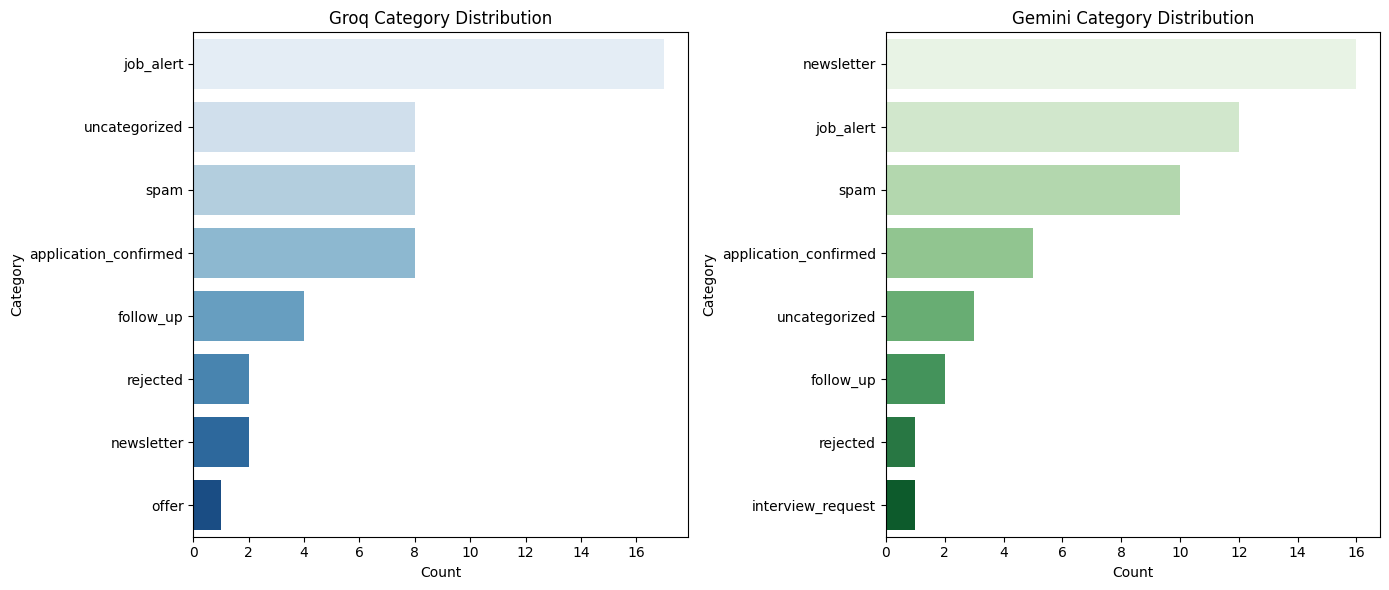

In [51]:
# 1️⃣ Distribution of categories for each model
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.countplot(y='groq_category', data=df, order=df['groq_category'].value_counts().index, palette='Blues')
plt.title("Groq Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")

plt.subplot(1, 2, 2)
sns.countplot(y='gemini_category', data=df, order=df['gemini_category'].value_counts().index, palette='Greens')
plt.title("Gemini Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")

plt.tight_layout()
plt.show()

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_22540\1455658367.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agreement_counts.index.astype(str), y=agreement_counts.values, palette=['green','red'])


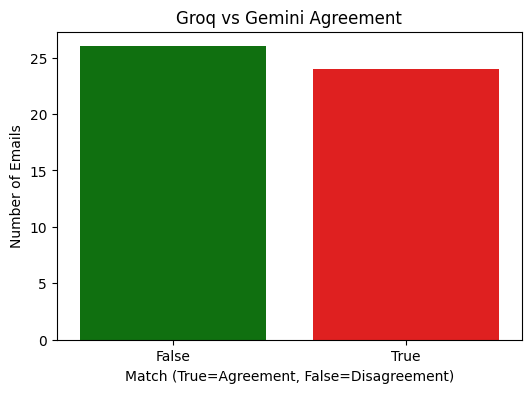

In [53]:
# 2️⃣ Agreement vs Disagreement
agreement_counts = df['match'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=agreement_counts.index.astype(str), y=agreement_counts.values, palette=['green','red'])
plt.title("Groq vs Gemini Agreement")
plt.xlabel("Match (True=Agreement, False=Disagreement)")
plt.ylabel("Number of Emails")
plt.show()

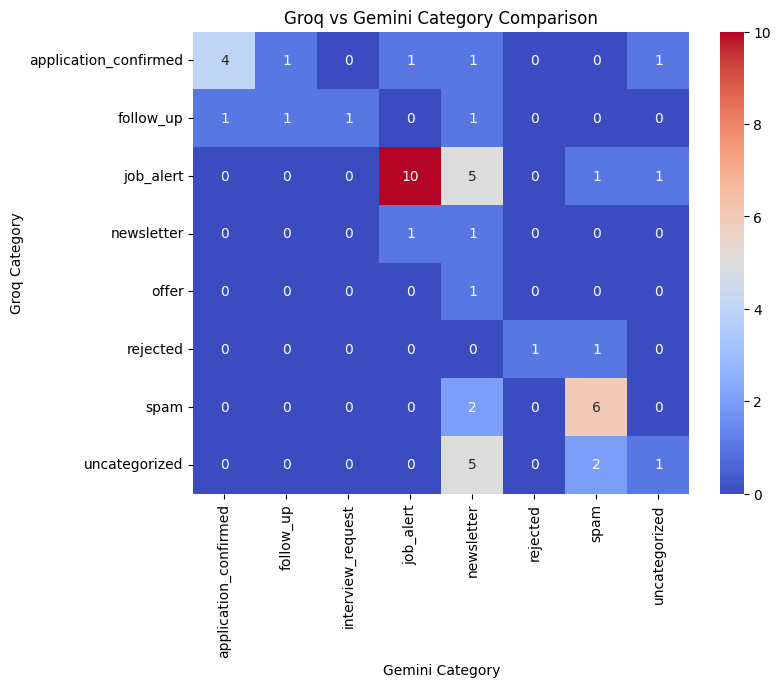

In [56]:
# 3️⃣ Cross-tab to see category-wise mismatches
cross_tab = pd.crosstab(df['groq_category'], df['gemini_category'])
plt.figure(figsize=(8,6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm')
plt.title("Groq vs Gemini Category Comparison")
plt.xlabel("Gemini Category")
plt.ylabel("Groq Category")
plt.show()

In [ ]:
import pandas as pd

## Adding True label to the email 
# Load the CSV
df = pd.read_csv("email_model_comparison_2025-11-17_20-12-39.csv")

# Add a new column for actual/ground-truth label if not exists
if "actual_category" not in df.columns:
    df["actual_category"] = ""

# Define all possible categories
CATEGORIES = [
    "application_confirmed",
    "interview_request",
    "interview_reminder",
    "offer",
    "rejected",
    "assessment",
    "follow_up",
    "job_alert",
    "newsletter",
    "spam",
    "uncategorized"
]

print("Instructions:")
print("Type the number corresponding to the correct category for each email.\n")

# Mapping for easier selection
cat_dict = {str(i+1): cat for i, cat in enumerate(CATEGORIES)}
for k, v in cat_dict.items():
    print(f"{k}: {v}")
print("\n--- Starting labeling ---\n")

# Loop through each email for labeling
for idx, row in df.iterrows():
    print(f"\nEmail {idx+1}/{len(df)}")
    print(f"Subject: {row['subject']}")
    print(f"Snippet: {row['snippet'][:200]}...")  # show first 200 chars

    # Show current categories predicted by models
    print(f"Groq prediction: {row['groq_category']}")
    print(f"Gemini prediction: {row['gemini_category']}")

    # Ask for input until a valid choice is made
    choice = ""
    while choice not in cat_dict.keys():
        choice = input("Enter correct category number: ")

    df.at[idx, "actual_category"] = cat_dict[choice]

# Save the updated CSV
output_file = "email_model_comparison_labeled.csv"
df.to_csv(output_file, index=False)
print(f"\n✅ Ground-truth labels saved to '{output_file}'")


Instructions:
Type the number corresponding to the correct category for each email.

1: application_confirmed
2: interview_request
3: interview_reminder
4: offer
5: rejected
6: assessment
7: follow_up
8: job_alert
9: newsletter
10: spam
11: uncategorized

--- Starting labeling ---


Email 1/50
Subject: 📅 Just scheduled: Networking and New Friends
Snippet: Canadian Networking. invites you to a new event‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌...
Groq prediction: uncategorized
Gemini prediction: newsletter

Email 2/50
Subject: Microsoft Power Platform Community is hiring in Canada
Snippet: View jobs in Canada ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ...
Groq prediction: job_alert
Gemini prediction: job_alert

Email 3/50
Subject: You've unlocked